In [7]:
##

In [1]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
prefix = 'mlops/data'
input_source = 's3://{data_path}

In [2]:
df = pd.read_parquet(input_source)

In [3]:
df.shape

(100000, 563)

In [4]:
df.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,date_time
156800,0.262871,0.013216,-0.086324,0.200015,-0.156414,-0.278659,0.111663,-0.230944,-0.271890,0.580217,...,-0.741163,0.121548,-0.833951,-0.904012,0.643397,-0.994826,0.094677,0.023043,WALKING_DOWNSTAIRS,2020-01-01 01:00:00
105861,0.279888,-0.016259,-0.108582,-0.956027,-0.967547,-0.972543,-0.955547,-0.963617,-0.969774,-0.907162,...,-0.733630,-0.110451,0.055678,0.006752,-0.149780,0.562788,-0.284655,-0.730306,LAYING,2020-01-01 01:01:00
14961,0.057557,-0.065914,-0.318505,-0.204595,-0.313841,0.121934,-0.244170,-0.336566,0.132129,-0.042670,...,-0.400585,0.077258,0.625433,0.948960,-0.535123,-0.556217,0.199724,0.317411,WALKING_UPSTAIRS,2020-01-01 01:02:00
182560,0.166638,0.009589,-0.093877,0.075222,0.129887,-0.170282,-0.037054,0.049850,-0.245201,0.404261,...,-0.477741,0.685372,0.344247,0.781544,0.139801,-0.855667,0.187082,0.038144,WALKING_DOWNSTAIRS,2020-01-01 01:03:00
156371,0.277392,-0.013888,-0.114378,-0.996323,-0.993373,-0.989750,-0.997365,-0.993227,-0.989991,-0.939918,...,-0.986440,0.043316,-0.202663,-0.192810,-0.372000,-0.673985,-0.055019,-0.155311,SITTING,2020-01-01 01:04:00


Text(0, 0.5, 'Activity Count')

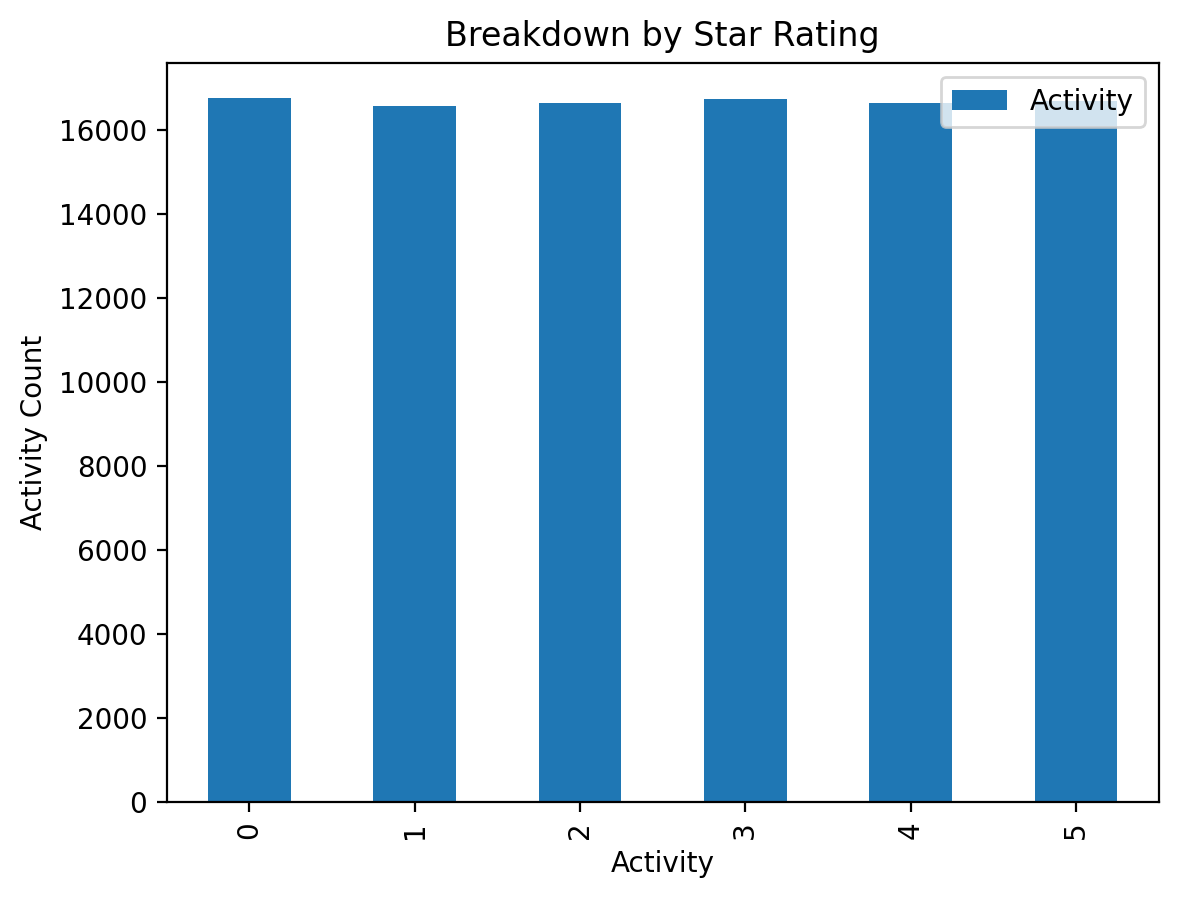

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

df.groupby("Activity")[['Activity']].count().plot(kind="bar", title="Breakdown by Star Rating")
plt.xlabel("Activity")
plt.ylabel("Activity Count")

## Feature Engineering with Amazon SageMaker Processing

In [19]:
%%writefile preprocessing.py

import pandas as pd
import numpy as np
import argparse
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
def _parse_args():

    parser = argparse.ArgumentParser()
    
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='Human_Activity_Recognition_Using_Smartphones_Data_augmented_timedata_sample.gzip')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')

    return parser.parse_known_args()


def get_top_k_features(X, Y, k):
        clf = ExtraTreesClassifier(n_estimators=50)
        clf = clf.fit(X, Y)
        feature_df = pd.DataFrame(
            data=(X.columns, clf.feature_importances_)
        ).T.sort_values(by=1, ascending=False)
        cols = feature_df.head(k)[0].values
        return cols

if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    # Load data
    print(args.filepath,args.filename)
    df = pd.read_parquet(os.path.join(args.filepath, args.filename))
    le = LabelEncoder()
    df['Activity'] = le.fit_transform(df['Activity'])
    df.drop(['date_time'],axis =1 ,inplace = True)
    ##
    X = df.drop(['Activity'], axis =1)
    Y = df['Activity']
    k =10
    final_cols = get_top_k_features(X, Y, k)
    final_cols = np.append(final_cols,np.array(['Activity']))
    df = df[final_cols]
    # Train, test, validation split
    train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=42), [int(0.7 * len(df)), int(0.9 * len(df))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%
    # Local store
    pd.concat([train_data['Activity'], train_data.drop(['Activity'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
    pd.concat([validation_data['Activity'], validation_data.drop(['Activity'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
    test_data[['Activity']].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
    test_data.drop(['Activity'], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
    print("## Processing complete. Exiting.")

Overwriting preprocessing.py


In [20]:
train_path = f"s3://{bucket}/{prefix}/train"
validation_path = f"s3://{bucket}/{prefix}/validation"
test_path = f"s3://{bucket}/{prefix}/test"

In [21]:
# cell 09
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role


sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=get_execution_role(),
    instance_type="ml.m5.large",
    instance_count=1, 
    base_job_name='sklearn-ml-train'
) 


sklearn_processor.run(
    code='preprocessing.py',
    inputs=[
        ProcessingInput(
            source=input_source, 
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            s3_data_distribution_type="ShardedByS3Key"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_path,
        ),
        ProcessingOutput(output_name="validation_data", source="/opt/ml/processing/output/validation", destination=validation_path),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/output/test", destination=test_path),
    ]
)

INFO:sagemaker:Creating processing-job with name sklearn-ml-train-2023-07-14-08-39-27-676


........................../opt/ml/processing/input/ Human_Activity_Recognition_Using_Smartphones_Data_augmented_timedata_sample.gzip
## Processing complete. Exiting.



## Training

In [23]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_path.format(bucket, prefix), 
                                                    content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=validation_path.format(bucket, prefix),
                                                     content_type='csv')

In [24]:
%%writefile sklearn-train.py

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from joblib import dump, load
import pandas as pd, numpy as np, os, argparse

# inference function - tells SageMaker how to load the model
def model_fn(model_dir):
    clf = load(os.path.join(model_dir, "model.joblib"))
    return clf

# Argument parser
def _parse_args():
    parser = argparse.ArgumentParser()
    # Hyperparameters
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)
    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train.csv")
    parser.add_argument("--test-file", type=str, default="test.csv")
    # Parse the arguments
    return parser.parse_known_args()

# Main Training Loop
if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    # Load the dataset
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    # Separate X and y
    X_train, y_train = train_df.drop(train_df.columns[0], axis=1), train_df[train_df.columns[0]]
    X_test, y_test = test_df.drop(test_df.columns[0], axis=1), test_df[test_df.columns[0]]
    # Define the model and train it
    model = RandomForestClassifier(
        n_estimators=args.n_estimators, min_samples_leaf=args.min_samples_leaf, n_jobs=-1
    )
    model.fit(X_train, y_train)
    # Evaluate the model performances
    print(f'Model Accuracy: {accuracy_score(y_test, model.predict(X_test))}')
    dump(model, os.path.join(args.model_dir, 'model.joblib'))

Overwriting sklearn-train.py


In [25]:
# cell 12
# We use the Estimator from the SageMaker Python SDK
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

# Define the Estimator from SageMaker (Script Mode)
sklearn_estimator = SKLearn(
    entry_point="sklearn-train.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    metric_definitions=[{"Name": "model_accuracy", "Regex": "Model Accuracy: ([0-9.]+).*$"}],
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 3,
        "test-file": "validation.csv"
    },
)

# Train the model (~5 minutes)
sklearn_estimator.fit({"train": s3_input_train, "test": s3_input_validation})

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Creating training-job with name: rf-scikit-2023-07-14-08-51-41-262


Using provided s3_resource
2023-07-14 08:51:41 Starting - Starting the training job...
2023-07-14 08:51:56 Starting - Preparing the instances for training......
2023-07-14 08:52:53 Downloading - Downloading input data...
2023-07-14 08:53:39 Training - Training image download completed. Training in progress..2023-07-14 08:53:40,423 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-07-14 08:53:40,426 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-14 08:53:40,464 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-07-14 08:53:40,613 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-14 08:53:40,625 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-14 08:53:40,635 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-14 08:53:40,643 sagemaker-training-toolkit I

## Hosting

In [31]:
# cell 13
sklearn_predictor = sklearn_estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: rf-scikit-2023-07-14-09-27-43-800
INFO:sagemaker:Creating endpoint-config with name rf-scikit-2023-07-14-09-27-43-800
INFO:sagemaker:Creating endpoint with name rf-scikit-2023-07-14-09-27-43-800


------!

## Prediction & Evaluation

In [33]:
sklearn_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [ ]:
!aws s3 cp $test_path/test_x.csv /tmp/test_x.csv
!aws s3 cp $test_path/test_y.csv /tmp/test_y.csv

In [44]:
test_x = pd.read_csv('/tmp/test_x.csv', names=[f'{i}' for i in range(10)])
test_y = pd.read_csv('/tmp/test_y.csv', names=['y'])
#predictions = sklearn_predictor.predict(test_x.values)

In [46]:
predictions = sklearn_predictor.predict(test_x)

In [49]:
pd.crosstab(index=test_y['y'].values, columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0,1,2,3,4,5
actuals,,,,,,
0,1705,0,0,0,0,0
1,0,1579,81,0,0,0
2,0,72,1599,0,0,0
3,0,0,0,1591,11,20
4,0,0,0,5,1660,15
5,0,0,0,11,19,1632


In [52]:
from sklearn.metrics import classification_report
print(classification_report(test_y['y'].values,  predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1705
           1       0.96      0.95      0.95      1660
           2       0.95      0.96      0.95      1671
           3       0.99      0.98      0.99      1622
           4       0.98      0.99      0.99      1680
           5       0.98      0.98      0.98      1662

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

